In [1]:
import pathlib
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt


import SessionTools.two_photon as st2p


%load_ext autoreload
%autoreload 2 

%matplotlib inline

In [2]:
session_info = {'date': "09_07_2024",
                'genotype_dir': 'R60D05LexA_jGCaMP7b_R18B05Gal4_TBHRNAi/gal4_control',
                'fly': 'fly4',
                'session': 'dark-005',
                'fictrac_scan_num': 5,
                'fictrac_dat_file' : 'fictrac-20240709_114658.dat',
                'full_genotype': '+/w-; R60D05LexA/UAS-TBH-RNAi^67968; +/LexOp-jGCaMP7b',
                'ecl date': '6/29-30/2024',
                'notes': ''}

session_info['fictrac_dir']= f"/media/mplitt/SSD_storage/fictrac_folder/{session_info['genotype_dir']}/{session_info['date']}/{session_info['fly']}"
bruker_folder = pathlib.PurePath('/media/mplitt/SSD_storage/2PData')
# pkl_path = pathlib.PurePath(f"/media/mplitt/SSD_storage/fictrac_folder/{session_info['genotype_dir']}/{session_info['date']}/{session_info['fly']}/fly1_1_scan0.pkl")

pp = st2p.preprocessing.EBImagingSession(session_info = session_info, 
                                         bruker_base_dir = bruker_folder,
                                         fictrac_dir = session_info['fictrac_dir'],
                                         fictrac_dat_file = session_info['fictrac_dat_file'],
                                         fictrac_scan_num = session_info['fictrac_scan_num'])
                                         # fictrac_pkl_path=pkl_path)

In [3]:
# pp.fictrac_pkl_path = pathlib.PurePath('/media/mplitt/SSD_storage/fictrac_folder/EL_jGCaMP7b_TBHRNAi/vacht_rnai/25_06_2024/fly1/fly1_scan1.pkl')

In [4]:
pp.extract_metadata()
pp.bruker_to_h5(first_chan=2, overwrite=False)
data_corr, shifts, error, diffphase= pp.motion_correct(pp.data)
pp.align_voltage_recording()
pp.align_fictrac()


(242, 294)
[                                        ] | 0% Completed | 478.44 ms

<tifffile.TiffFile 'dark-005_Cycle00…_000005.ome.tif'> OME series is BinaryOnly, not an OME-TIFF master file 


[########################################] | 100% Completed | 34.94 s


In [5]:
nap = pp.open_napari()

In [6]:
print(pp.voltage_recording_aligned.columns)

Index(['Time(ms)', ' Start Trigger', ' Opto Trigger', ' FicTrac Cam Exp.',
       ' FicTrac Frame Proc.', ' Heading', ' Y/Index', ' Arena DAC1',
       ' Arena DAC2', ' Heading_cartx', ' Heading_carty', ' Arena DAC1_cartx',
       ' Arena DAC1_carty'],
      dtype='object')


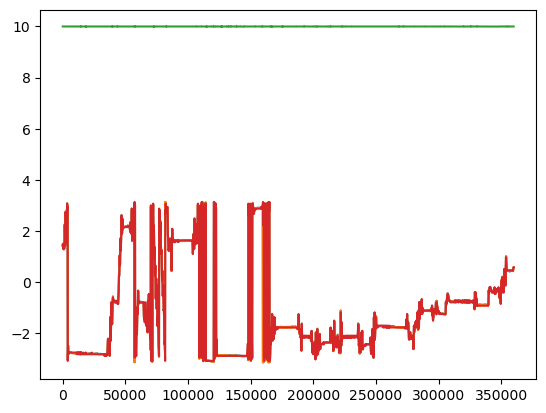

In [7]:
fig, ax = plt.subplots()
time = pp.fictrac_aligned['Time(ms)']
inds = slice(0,100000)
ax.plot(time[inds],pp.fictrac_aligned['integ heading (lab)'].iloc[inds])
ax.plot(time[inds], pp.voltage_recording_aligned[' Heading'].iloc[inds])
# ax.plot(time[inds], pp.voltage_recording_aligned[' Arena DAC2'].iloc[inds])
ax.plot(time[inds], pp.voltage_recording_aligned[' Y/Index'].iloc[inds])
ax.plot(time[inds], pp.voltage_recording_aligned[' Arena DAC1'].iloc[inds])

In [8]:
print('')

In [9]:
# 

In [10]:
n_rois = 16
nap.make_phase_masks(n_rois=n_rois)
pp.get_layers(nap)
pp.extract_timeseries(max_proj=False)

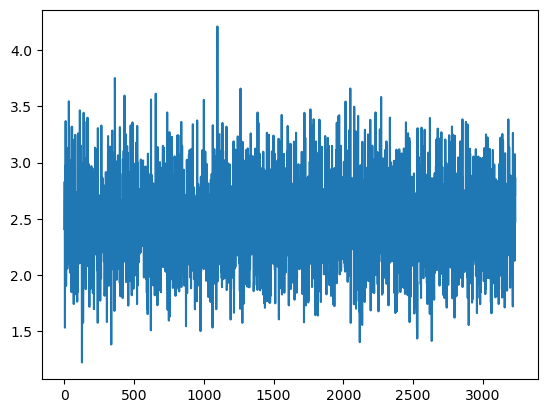

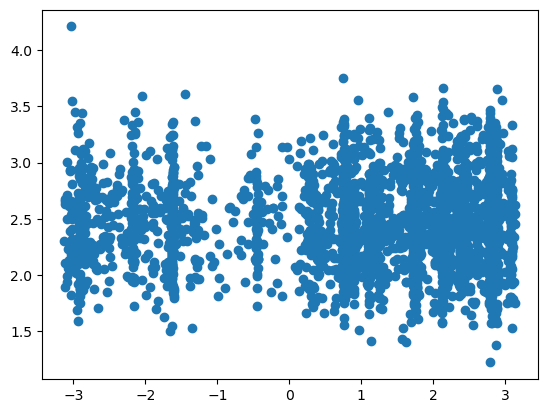

In [11]:
fig, ax= plt.subplots()
ax.plot(pp.timeseries['background'][-1,0,:])
fig, ax= plt.subplots()
heading = -1* pp.voltage_recording_aligned[' Heading'].to_numpy()
ax.scatter(heading, pp.timeseries['background'][-1,0,:])

In [12]:
y = pp.calculate_zscored_F('rois', exp_detrend=True, zscore=True)

In [13]:
pp.save()

In [14]:
if False:
    gd = session_info['genotype_dir']
    d = session_info['date']
    f = session_info['fly']
    s = session_info['session']
    outdir = pathlib.PurePath(f'/media/mplitt/SSD_storage/2P_scratch/{gd}/{d}/{f}/{s}/preprocess.pkl')
    print(outdir)
    pp = st2p.preprocessing.EBImagingSession.from_file(outdir)
    y = pp.timeseries['rois_z']
    n_rois=y.shape[1]
    heading = -1* pp.voltage_recording_aligned[' Heading'].to_numpy()
    # print(pp.session_info)

(3234,) (3234,)


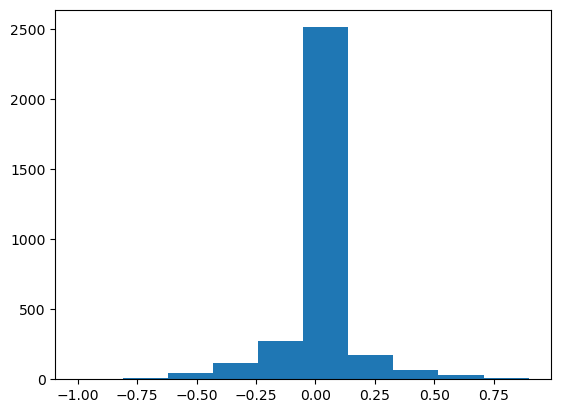

In [15]:
dh = np.angle(np.exp(1j*np.ediff1d(pp.voltage_recording_aligned[' Heading'].to_numpy(), to_end=0)))
fig, ax= plt.subplots()
ax.hist(dh)

y_sm = sp.ndimage.gaussian_filter1d(sp.ndimage.gaussian_filter1d(y-1, 1, axis=-1),.7,axis=1, mode='wrap')
# y_sm = sp.ndimage.gaussian_filter1d(y-1, 1, axis=-1)
# y_sm = y-1

x_f,y_f = st2p.utilities.pol2cart(y_sm[-1,:,:],np.linspace(-np.pi,np.pi,num=n_rois)[:,np.newaxis])
rho,phi = st2p.utilities.cart2pol(x_f.mean(axis=0), y_f.mean(axis=0))
print(rho.shape, phi.shape)



_,offset = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(heading.shape),phi-heading))

Index(['Time(ms)', ' Start Trigger', ' Opto Trigger', ' FicTrac Cam Exp.',
       ' FicTrac Frame Proc.', ' Heading', ' Y/Index', ' Arena DAC1',
       ' Arena DAC2', ' Heading_cartx', ' Heading_carty', ' Arena DAC1_cartx',
       ' Arena DAC1_carty'],
      dtype='object')
(1, 16, 3234) (3234,)


Text(0.5, 1.0, 'offset variance = 0.7635840649726184')

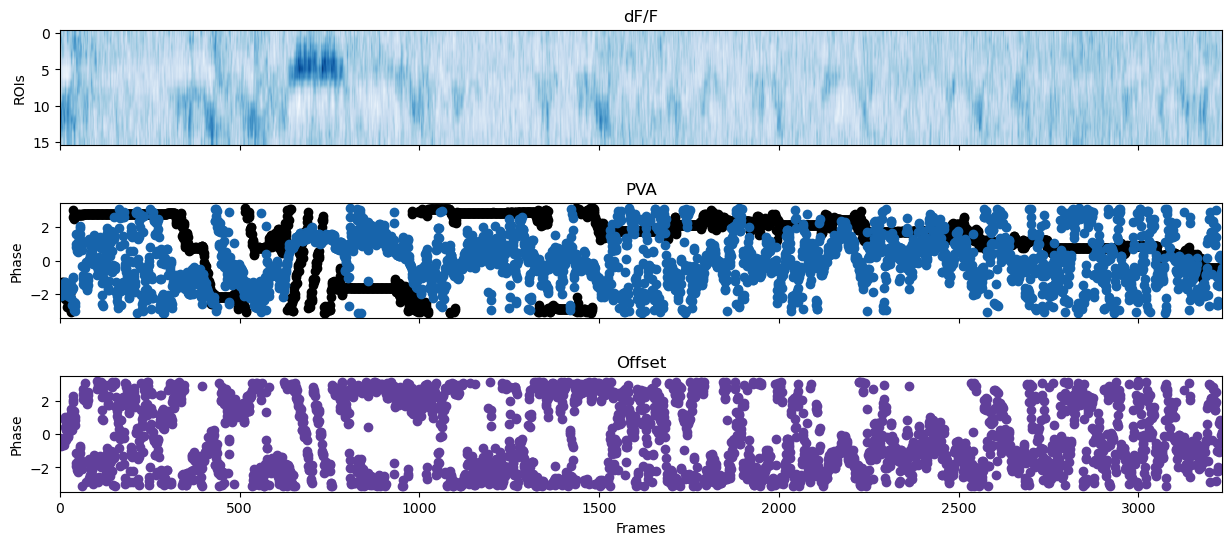

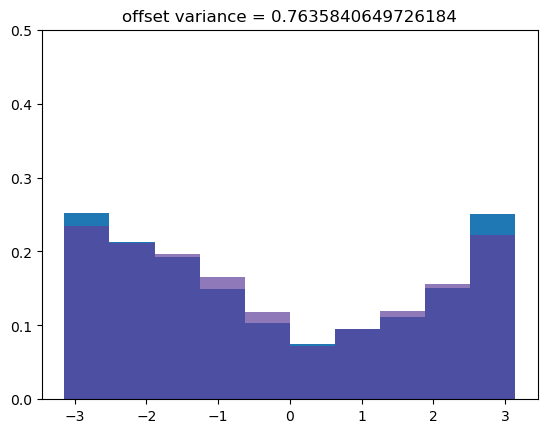

In [16]:
fig, ax= plt.subplots(3,1, figsize=[15,6], sharex=True)
fig.subplots_adjust(hspace=.5)
ax[0].imshow(y_sm[-1,::-1,:], aspect='auto', cmap= 'Blues') #, vmin=-.3, vmax=.7)
# ax.scatter(np.arange(y.shape[-1]), 15*(phi+np.pi)/2/np.pi)

print(pp.voltage_recording_aligned.columns)
# fig, ax= plt.subplots()

x = np.arange(y.shape[-1])
print(y.shape, heading.shape)
ax[1].scatter(x,heading, color='black')
ax[1].scatter(x, phi, color=plt.cm.Blues(.8))
ax[2].scatter(x, offset, color=plt.cm.Purples(.8))
ax[0].set_ylabel('ROIs')
ax[0].set_title('dF/F')

ax[1].set_ylabel('Phase')
ax[1].set_title('PVA')

ax[2].set_ylabel('Phase')
ax[2].set_xlabel('Frames')
ax[2].set_title('Offset')



mask = ((heading<-1) | (heading>1))
# mask = np.abs(dh)>.1
fig, ax= plt.subplots()
ax.hist(offset[mask], density=True)
ax.hist(offset, alpha=.7, density=True, facecolor=plt.cm.Purples(.8))
ax.set_ylim([0,.5])
o = sp.stats.circvar(offset)
ax.set_title(f'offset variance = {o}')

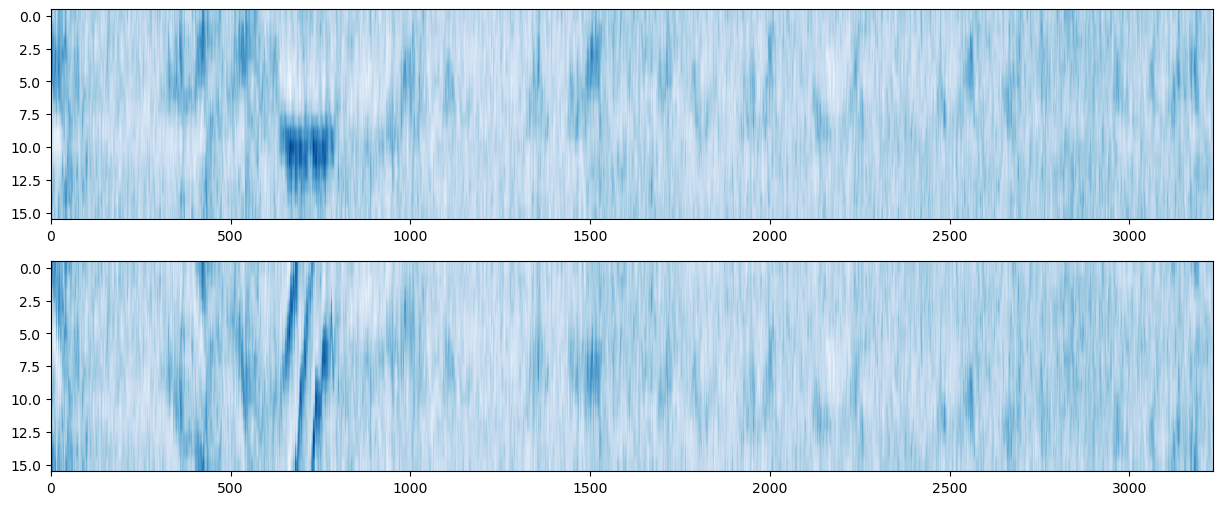

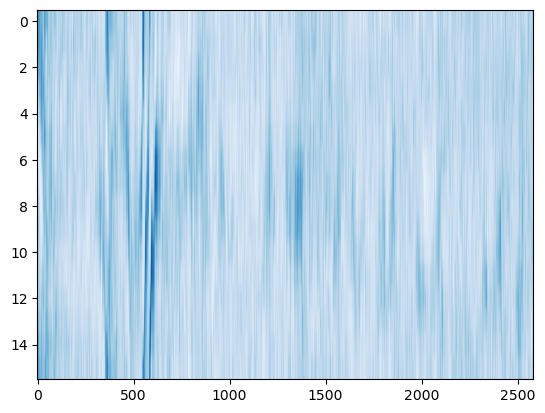

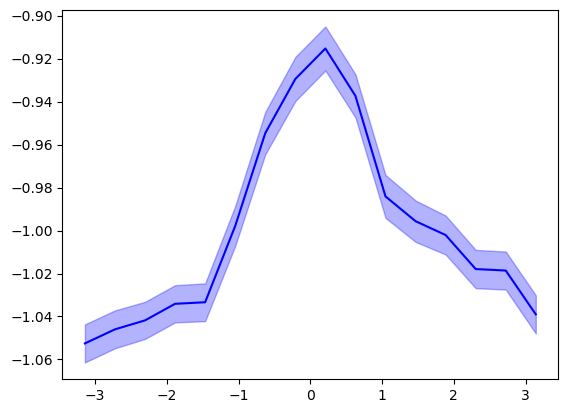

In [17]:
heading_ind = ((n_rois-1)*(heading+np.pi)/2/np.pi).astype(int)
# print(heading_ind, y_sm.shape)

y_sm_heading_aligned = np.zeros_like(y_sm)
for ind in range(heading.shape[0]):
    y_sm_heading_aligned[-1,:,ind] = np.roll(y_sm[-1,:,ind], -heading_ind[ind])
    
fig, ax= plt.subplots(2,1, figsize=[15,6])
ax[0].imshow(y_sm[-1,:, :] , cmap='Blues',aspect='auto')
ax[1].imshow(y_sm_heading_aligned[-1,:,:] , cmap='Blues',aspect='auto')

# y_sm_ha = y
mu = y_sm_heading_aligned[:,:,:].mean(axis=-1)[-1,:]
sem = sp.stats.sem(y_sm_heading_aligned[:,:,:], axis=-1)[-1,:]
# print(mu.shape, sem.shape)
fig, ax = plt.subplots()
ax.imshow(y_sm_heading_aligned[:,:,mask][-1,:,:], cmap='Blues', aspect='auto')

fig, ax= plt.subplots()
ax.fill_between(np.linspace(-np.pi, np.pi, num=n_rois), mu-sem, mu+sem, alpha=.3, color='blue')
ax.plot(np.linspace(-np.pi, np.pi, num=n_rois), mu, color='blue')

In [18]:
print(sp.stats.circvar(offset), sp.stats.circvar(offset[mask]))

0.7635840649726184 0.7313809731921519
